In [ ]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
import numpy as np

from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

import datetime

%load_ext tensorboard

In [ ]:
# Clear any logs from previous runs
# rm -rf ./data/logs/

In [ ]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS = 20

In [56]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "../data/Train",
    seed = 123,
    shuffle = True,
    image_size = (IMAGE_SIZE, IMAGE_SIZE),
    batch_size = BATCH_SIZE
)

Found 383 files belonging to 4 classes.


In [57]:
class_names = dataset.class_names
class_names

['Blotch_Apple', 'Normal_Apple', 'Rot_Apple', 'Scab_Apple']

In [58]:
# len(dataset)

In [59]:
testset = tf.keras.preprocessing.image_dataset_from_directory(
    "../data/Test",
    seed = 123,
    shuffle = True,
    image_size = (IMAGE_SIZE, IMAGE_SIZE),
    batch_size = BATCH_SIZE
)

Found 120 files belonging to 4 classes.


In [60]:
class_names = testset.class_names
class_names

['Blotch_Apple', 'Normal_Apple', 'Rot_Apple', 'Scab_Apple']

In [61]:
# len(testset)

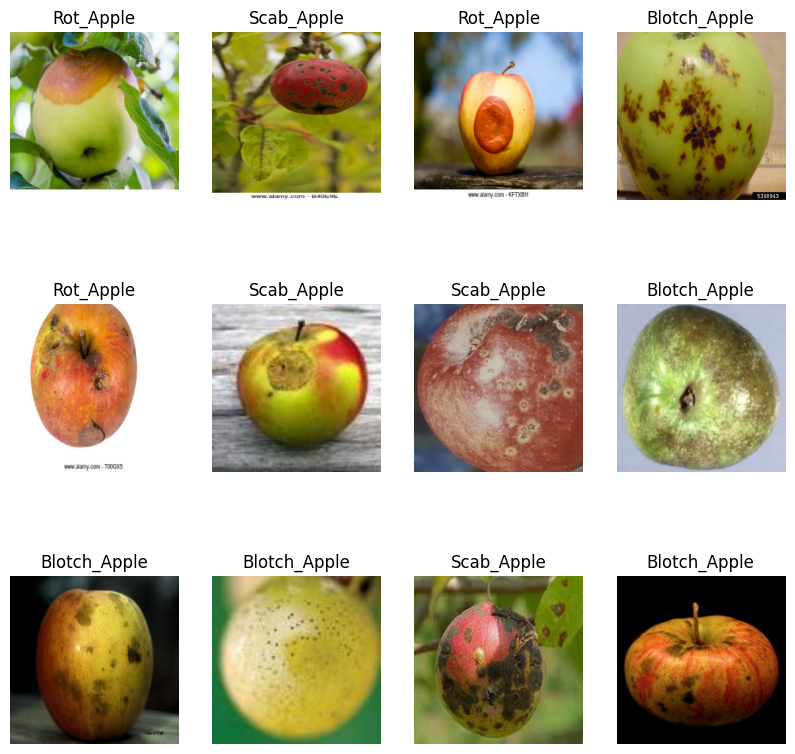

In [62]:
plt.figure(figsize=(10, 10)) # om dimensies totale afbeelding aan te passen en tekst leesbaar te houden
for image_batch, label_batch in dataset.take(1): # toont at random afbeeldingen uit de dataset
    # print(image_batch.shape)
    # print(label_batch.numpy())
    # print(image_batch[0].numpy)
    # print(image_batch[0].shape)
    for i in range(12):
        ax = plt.subplot(3, 4, i+1)    
        # plt.imshow(image_batch[0].numpy().astype("uint8"))
        # plt.title(class_names[label_batch[0]])
        plt.imshow(image_batch[i].numpy().astype("uint8")) # met [i] ipv [0] wordt de loop doorlopen en 12 afb. getoond
        plt.title(class_names[label_batch[i]])
        plt.axis("off") # om extra informatie (> assen) uit te zetten

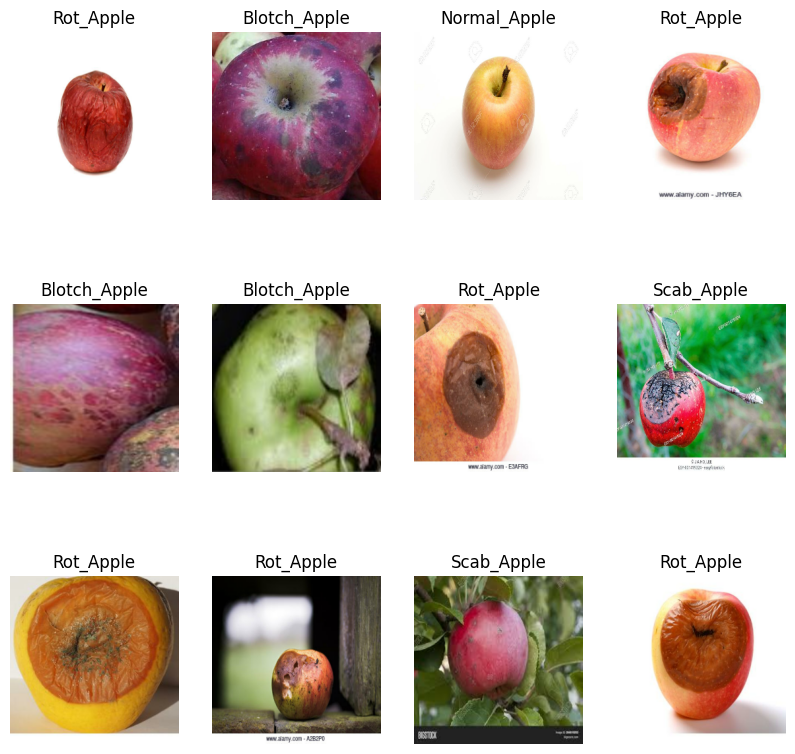

In [63]:
plt.figure(figsize=(10, 10)) # om dimensies totale afbeelding aan te passen en tekst leesbaar te houden
for image_batch, label_batch in testset.take(1): # toont at random afbeeldingen uit de dataset
    for i in range(12):
        ax = plt.subplot(3, 4, i+1)    
        plt.imshow(image_batch[i].numpy().astype("uint8")) 
        plt.title(class_names[label_batch[i]])
        plt.axis("off") 

In [64]:
train_size = 0.8
len(dataset)*train_size

9.600000000000001

In [65]:
train_ds = dataset.take(9) # met .take() worden de eerste (x) batches geslecteerd
len(train_ds)

9

In [66]:
# test_ds = dataset.skip() # met .skip() worden er overgeslagen
# omdat we een aparte folder voor de test-dataset hebben, kunnen we deze als onderstaand inladen
test_ds = testset
len(test_ds) # lengte in batches

4

In [67]:
val_size = 0.2
len(dataset)*val_size

2.4000000000000004

In [68]:
val_ds = dataset.skip(9)
len(val_ds)

3

In [69]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.2, shuffle=True, shuffle_size=10000):

    assert (train_split + val_split) == 1 # test_split niet want extra folder

    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
        
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)
    
    val_ds = ds.skip(train_size).take(val_size)
    # test_ds = ds.skip(train_size).skip(val_size) # als we de test-dataset ook uit dezelfde batch/folder zouden halen
    test_ds = testset
        
    return train_ds, val_ds, test_ds

In [70]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [71]:
# len(train_ds)

In [72]:
# len(val_ds)

In [73]:
# len(test_ds)

In [74]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE) ## bij CPU én GPU gebruik.
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [75]:
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE,IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1./255)    
])

In [76]:
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2),
])

Apply data augmentation to train dataset

In [77]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

In [78]:
tf.keras.layers.BatchNormalization(
    axis=-1,
    momentum=0.99,
    epsilon=0.001,
    center=True,
    scale=True,
    beta_initializer='zeros',
    gamma_initializer='ones',
    moving_mean_initializer='zeros',
    moving_variance_initializer='ones',
    beta_regularizer=None,
    gamma_regularizer=None,
    beta_constraint=None,
    gamma_constraint=None,
)

# minus **kwargs

In [79]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 4

model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32, (3,3), activation='relu', input_shape=input_shape),
    # tf.keras.layers.BatchNormalization(),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),   
    layers.Dropout(0.2), 
    layers.Conv2D(128, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(128, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(258, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),    
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax')          
])

model.build(input_shape=input_shape)

In [80]:
# callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)

In [81]:
# model.summary()

In [82]:
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

In [83]:
model.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [84]:
history = model.fit(
    train_ds,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1,
    validation_data=val_ds,
    callbacks = [tensorboard_callback]
)

Epoch 1/20
9/9 [==============================] - 9s 694ms/step - loss: 1.3793 - accuracy: 0.3066 - val_loss: 1.3666 - val_accuracy: 0.3594
Epoch 2/20
9/9 [==============================] - 5s 541ms/step - loss: 1.3554 - accuracy: 0.2927 - val_loss: 1.3433 - val_accuracy: 0.3281
Epoch 3/20
9/9 [==============================] - 5s 483ms/step - loss: 1.3299 - accuracy: 0.3136 - val_loss: 1.3144 - val_accuracy: 0.4219
Epoch 4/20
9/9 [==============================] - 3s 359ms/step - loss: 1.2913 - accuracy: 0.3554 - val_loss: 1.2779 - val_accuracy: 0.4844
Epoch 5/20
9/9 [==============================] - 3s 315ms/step - loss: 1.2354 - accuracy: 0.4355 - val_loss: 1.2300 - val_accuracy: 0.4844
Epoch 6/20
9/9 [==============================] - 3s 334ms/step - loss: 1.1773 - accuracy: 0.4599 - val_loss: 1.1639 - val_accuracy: 0.5312
Epoch 7/20
9/9 [==============================] - 3s 298ms/step - loss: 1.1380 - accuracy: 0.4739 - val_loss: 1.1341 - val_accuracy: 0.5781
Epoch 8/20
9/9 [====

In [85]:
scores = model.evaluate(test_ds)

4/4 [==============================] - 0s 44ms/step - loss: 1.0943 - accuracy: 0.5250


In [86]:
# scores

In [87]:
# history

In [88]:
# history.params

In [89]:
# history.history.keys()

In [90]:
# len(history.history['accuracy'])

In [91]:
# type(history.history['loss'])
# len(history.history['loss'])

In [92]:
# history.history['loss'][:5]# show loss for first 5 epochs

In [93]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

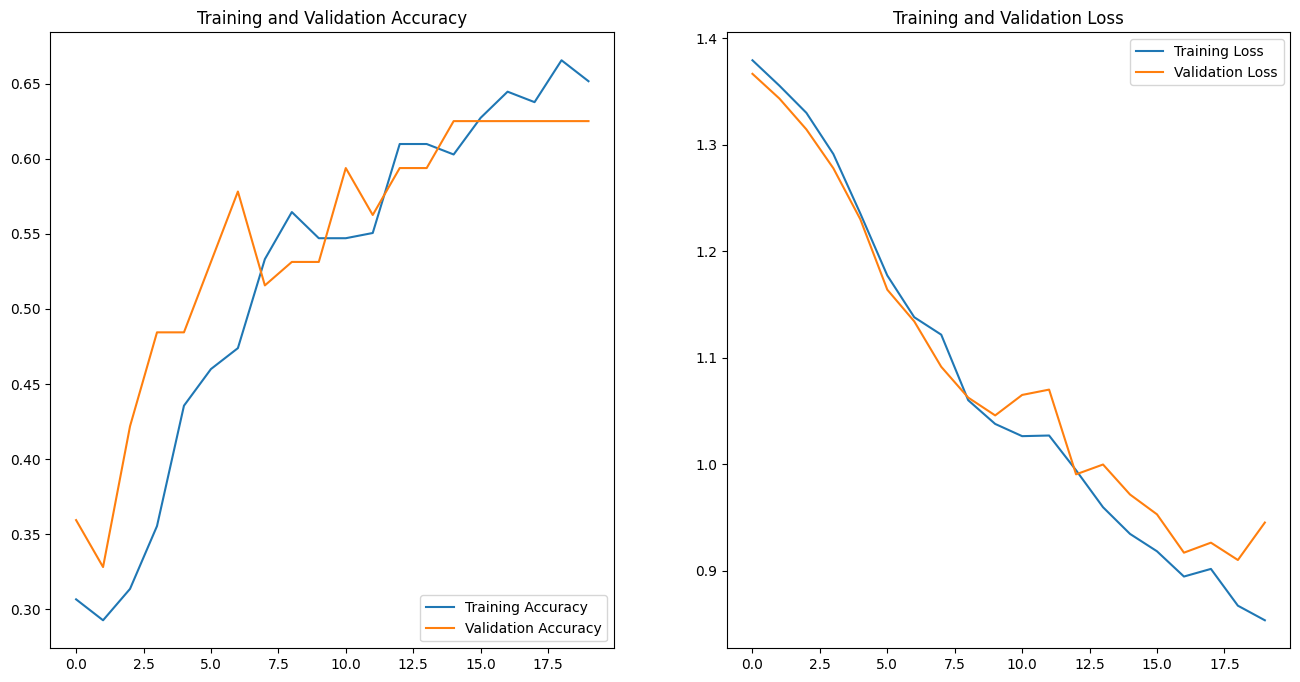

In [94]:
plt.figure(figsize=(16, 8))

plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.show()

First image to predict
First image's actual label: Normal_Apple
Predicted label: Normal_Apple


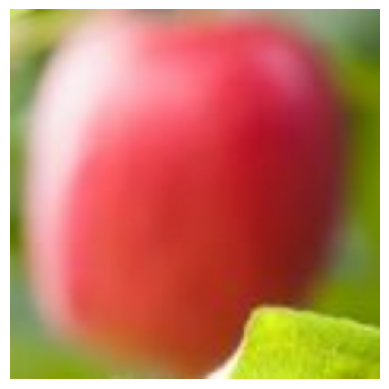

In [95]:
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("First image to predict")
    plt.imshow(first_image)
    plt.axis("off")
    print("First image's actual label:", class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("Predicted label:", class_names[np.argmax(batch_prediction[0])])
    # print(batch_prediction[0]) # input for np.argmax() above
    

In [96]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images_batch[i])
    img_array = tf.expand_dims(img_array, 0) # Create a batch
    
    predictions = model.predict(img_array)
       
    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence
                                  

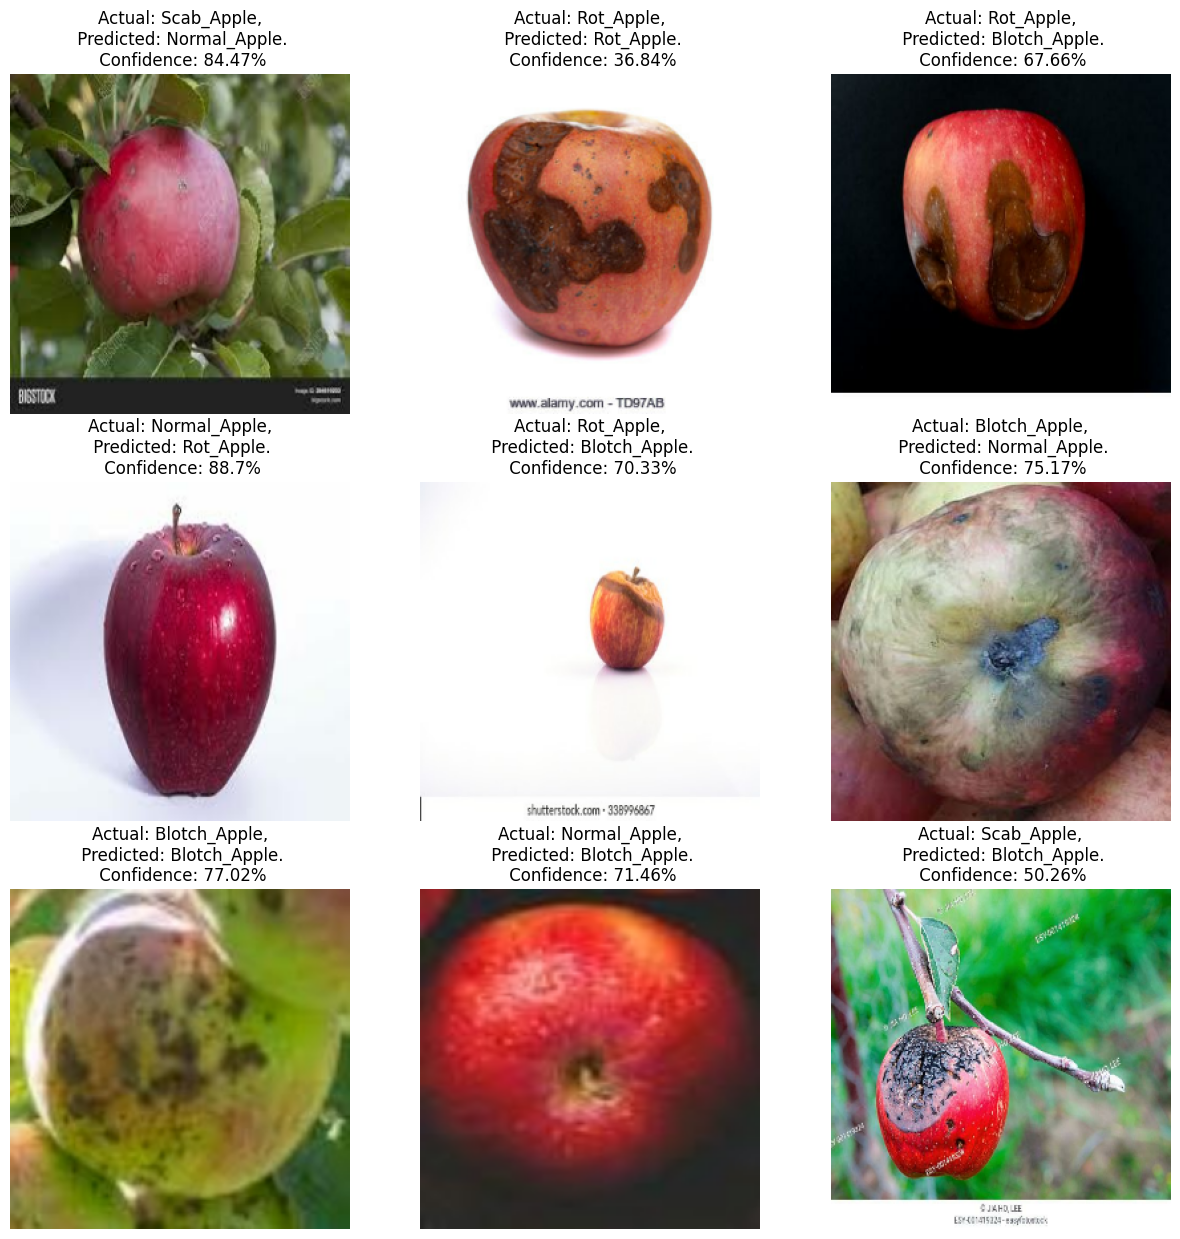

In [97]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i+1)
        
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy()) 
        actual_class = class_names[labels[i]]
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

In [98]:
import os

model_version=max([int(i) for i in os.listdir("../models") + [0]])+1
model.save(f"../models/apple_disease_class_{model_version}") # check ValueError: invalid literal for int() with base 10: '.gitkeep' <<<

INFO:tensorflow:Assets written to: ../models/apple_disease_class_5\assets


In [99]:
model.save("..models/../apples.h5")

In [100]:
model.predict(test_ds)

array([[0.18782975, 0.14207406, 0.571731  , 0.09836525],
       [0.70696187, 0.04055118, 0.16723569, 0.08525126],
       [0.59441316, 0.06512299, 0.18856233, 0.15190156],
       [0.72223294, 0.03433798, 0.07627245, 0.16715658],
       [0.5753956 , 0.05796583, 0.08688046, 0.2797581 ],
       [0.7626849 , 0.03124739, 0.11532909, 0.09073859],
       [0.18409313, 0.03234066, 0.7572886 , 0.02627764],
       [0.28420657, 0.06507283, 0.5921266 , 0.05859398],
       [0.10280062, 0.05054476, 0.8218542 , 0.02480036],
       [0.00497889, 0.17328466, 0.8168297 , 0.00490678],
       [0.6458587 , 0.04182259, 0.08067115, 0.23164763],
       [0.45297635, 0.10010486, 0.29890376, 0.14801505],
       [0.27467707, 0.13600461, 0.3161653 , 0.273153  ],
       [0.79828805, 0.03065522, 0.07794509, 0.0931116 ],
       [0.4065265 , 0.03145811, 0.5209542 , 0.04106116],
       [0.15036418, 0.3307055 , 0.2935341 , 0.22539628],
       [0.01897293, 0.09920115, 0.86793524, 0.01389072],
       [0.663772  , 0.05029515,

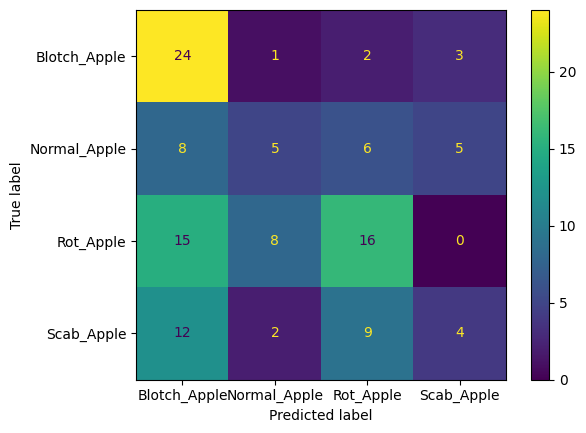

In [101]:
predictionBatch = model.predict(test_ds)
predictionEnhanced = tf.argmax(predictionBatch, axis=-1)
actualCategories = tf.concat([y for x, y in test_ds], axis=0)

confusionMatrix = metrics.confusion_matrix(actualCategories, predictionEnhanced)

cmDisplay = metrics.ConfusionMatrixDisplay(confusion_matrix = confusionMatrix, display_labels = ["Blotch_Apple", "Normal_Apple", "Rot_Apple", "Scab_Apple"])

cmDisplay.plot()

plt.show()

In [102]:
%tensorboard --logdir logs/fit

Reusing TensorBoard on port 6006 (pid 17836), started 1 day, 2:44:43 ago. (Use '!kill 17836' to kill it.)